<span style="font-family: Arial; font-weight:bold;font-size:2.5em;color:#00b3e5;"> Convolution Neural Network Project

DOMAIN: Botanical research

• CONTEXT: University X is currently undergoing some research involving understanding the characteristics of 
plant and plant seedlings at various stages of growth. They already have have invested on curating sample 
images. They require an automation which can create a classifier capable of determining a plant's species from a 
photo

• DATA DESCRIPTION: The dataset comprises of images from 12 plant species. Source: https://www.kaggle.com/c/plant-seedlings-classification/data

• PROJECT OBJECTIVE: University’s management require an automation which can create a classifier capable of 
determining a plant's species from a photo

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
# Import Libraries
import warnings
warnings.filterwarnings("ignore")
import math
import os as os
from PIL import Image
from array import array
import cv2 as cv2
from glob import glob
import time
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import preprocessing
import PIL
import pathlib
from pathlib import Path

# Importing the Keras libraries and packages
from keras.utils import np_utils
from sklearn import preprocessing
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Activation, Dense
seed = 8
np.random.seed(seed)

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.models import model_from_json
import itertools

In [4]:
pathToTrain = "/content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/train/"
testPath = "/content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/Seedling - Prediction/"

<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#00b3e5;">1) Import DataSet

In [5]:
listing = os.listdir(pathToTrain)
print(f'number of folders are : {len(listing)}')
print ('folder names are : ')
for imgFolder in listing:
  print(imgFolder)

number of folders are : 12
folder names are : 
Charlock
Common wheat
Fat Hen
Cleavers
Maize
Black-grass
Loose Silky-bent
Common Chickweed
Shepherds Purse
Small-flowered Cranesbill
Scentless Mayweed
Sugar beet


In [6]:
folders = []
image_numbers = []
image_all = []
image_category = []
for cat in listing: 
  print(cat)   # folder name in the directory
  path=os.path.join(pathToTrain,cat)
  number_image = len(os.listdir(path))
  print(f'number of images in {cat}  folder are : {number_image}') # checking number of folders
  print('')
  folders.append(cat) # all category names are added in folders variable
  image_numbers.append(number_image)
  for img in os.listdir(path):
    img_array=cv2.imread(os.path.join(path,img)) # reading images from each folder(category)
    image_all.append(img_array) # images are added to image_all
    image_category.append(listing.index(cat)) # category index value same as one hot encoding
  print(f'loaded category:{cat} successfully')

Charlock
number of images in Charlock  folder are : 390

loaded category:Charlock successfully
Common wheat
number of images in Common wheat  folder are : 221

loaded category:Common wheat successfully
Fat Hen
number of images in Fat Hen  folder are : 475

loaded category:Fat Hen successfully
Cleavers
number of images in Cleavers  folder are : 287

loaded category:Cleavers successfully
Maize
number of images in Maize  folder are : 221

loaded category:Maize successfully
Black-grass
number of images in Black-grass  folder are : 263

loaded category:Black-grass successfully
Loose Silky-bent
number of images in Loose Silky-bent  folder are : 671

loaded category:Loose Silky-bent successfully
Common Chickweed
number of images in Common Chickweed  folder are : 611

loaded category:Common Chickweed successfully
Shepherds Purse
number of images in Shepherds Purse  folder are : 241

loaded category:Shepherds Purse successfully
Small-flowered Cranesbill
number of images in Small-flowered Cranes

<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#00b3e5;">Visual representation of images per category

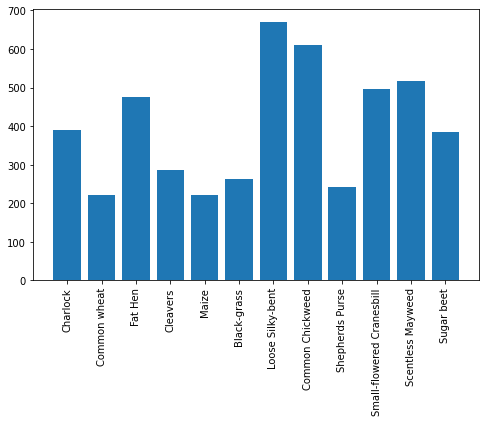

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
ax = fig.add_subplot(111)
ax.bar(folders,image_numbers)
plt.xticks(rotation = 90)
plt.show()

In [8]:
len(image_all)
#We can observe that total number of images are 4777

4777

In [9]:
image_all[1].shape # shape of first image

(166, 166, 3)

<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#00b3e5;"> Check max, min and average dimensions of an image in  total images

max dimension of an image is : (3457, 3991, 3)
min dimension of an image is : (49, 49, 3)

369.7322587397949
370.4638894703789


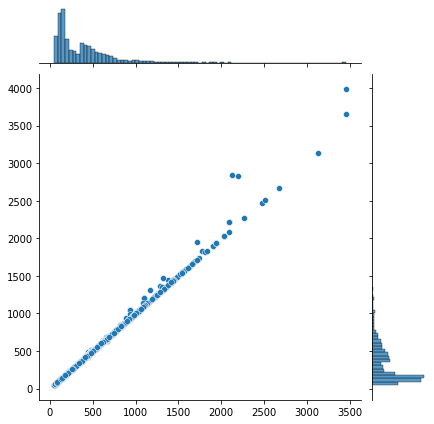

In [10]:
import seaborn as sns
dimension = []
dim1 = []
dim2 = []
for i in range(len(image_all)):
   image_dimension = image_all[i].shape
   d1,d2,colors = image_all[i].shape
   dimension.append(image_dimension)
   dim1.append(d1)
   dim2.append(d2)
print(f'max dimension of an image is : {max(dimension)}')
print(f'min dimension of an image is : {min(dimension)}')
print('')
print(np.mean(dim1))
print(np.mean(dim2))

sns.jointplot(dim1,dim2)

<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#00b3e5;"> Display first 12 images 

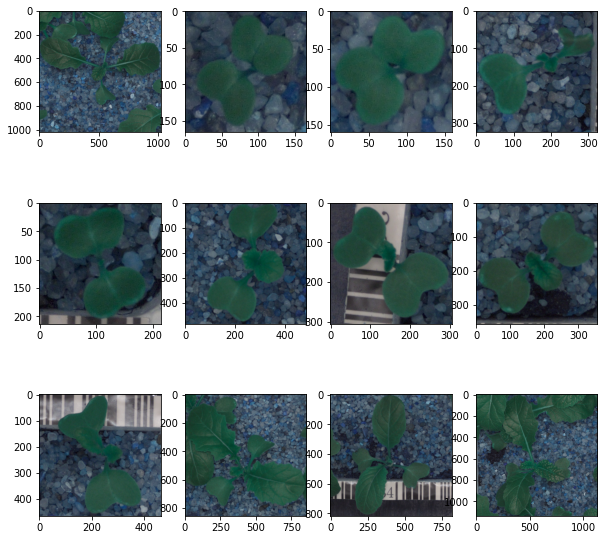

In [11]:
fig=plt.figure(figsize=(10,10))
for i in range(12):
  plt.subplot(3,4, i+1)
  plt.imshow(image_all[i])
 

In [12]:
from IPython.display import clear_output
# resize all images to 64*64
X_flatten = []
X_resize = []
Y_Index = []
scale_to = 64
a=0
for cat in listing: 
  path=os.path.join(pathToTrain,cat)
  class_num = listing.index(cat)
  for img in os.listdir(path):
    image = os.path.join(path, img)
    image = cv2.imread(image, cv2.IMREAD_ANYCOLOR)
    image = cv2.resize(image , (scale_to, scale_to))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    X_resize.append(image)
    X_flatten.append(image.flatten())
    #X.append(cv2.flip(image,-1))
    Y_Index.append(class_num)
   #Y.append(class_num)
    a+=1
  clear_output()
  print(a)
print(f"resize shape is : {X_resize[1].shape}")
print(f"flatten shape is : {X_flatten[1].shape}")

4777
resize shape is : (64, 64, 3)
flatten shape is : (12288,)


**sample images**

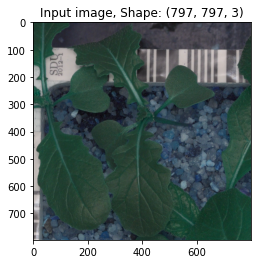

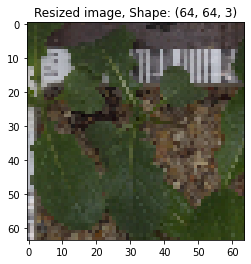

In [13]:
plt.imshow(image_all[100])
plt.title('Input image, Shape: '+str(image_all[100].shape))
plt.show()

# Resized image
plt.imshow(X_resize[100])
plt.title('Resized image, Shape: '+str(X_resize[100].shape))
plt.show()

In [14]:

Input_array = np.array(X_flatten)/255
Y_target = np.array(Y_Index)
print(Input_array.shape)


(4777, 12288)


In [15]:
Y_target.shape

(4777,)

In [16]:
df=pd.DataFrame(Input_array) #dataframe
df['Target']=Y_target
x=df.iloc[:,:-1] #input data 
y=df.iloc[:,-1] #output data

**Split X and y into training and test set in 80:20 ratio**

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.20, random_state = 8)   #split the data into train nd validation data


In [18]:
X_train.shape

(3821, 12288)

In [19]:
Y_train.shape

(3821,)

<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#00b3e5;">2)Model training, testing and tuning Image classification:

<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#00b3e5;">2.1) Supervised machine Learning

Most common and widely used  machine learning algorithms to solve image classification are,
- K-Nearest Neighbor (KNN) and Support Vector Machine (SVM).

But these are really works well for small datasets. However, when addressing a large dataset
with more complicated features and classes, deep learning outweighs traditional machine learning

** Using SVM** 

In [20]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# instantiate classifier with default hyperparameters
svc=SVC() 


# fit classifier to training set
svc.fit(X_train,Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [21]:
# import metrics to compute accuracy
from sklearn.metrics import accuracy_score

# make predictions on test set
y_pred=svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(Y_test, y_pred)))


Model accuracy score with default hyperparameters: 0.4738


In [22]:
results = []
results.append('svm')
results.append(accuracy_score(Y_test, y_pred)*100)

In [23]:
from sklearn.metrics import classification_report
print("classification  Matrix:\n",classification_report(Y_test,y_pred))

classification  Matrix:
               precision    recall  f1-score   support

           0       0.49      0.62      0.54        65
           1       1.00      0.02      0.04        50
           2       0.44      0.31      0.36       101
           3       0.60      0.49      0.54        55
           4       0.89      0.17      0.29        46
           5       0.30      0.14      0.19        58
           6       0.38      0.84      0.53       131
           7       0.45      0.63      0.53       108
           8       0.50      0.02      0.04        49
           9       0.69      0.70      0.70       103
          10       0.54      0.47      0.51       116
          11       0.42      0.43      0.42        74

    accuracy                           0.47       956
   macro avg       0.56      0.40      0.39       956
weighted avg       0.53      0.47      0.44       956



**Using KKN**

In [25]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors= 5 , metric = 'euclidean' )

In [26]:
KNN.fit(X_train,Y_train)
predicted_labels = KNN.predict(X_test)

In [27]:
print('Accuracy on Test data:',KNN.score(X_test, Y_test) )

Accuracy on Test data: 0.24581589958158995


In [28]:
results = []
results.append('KNN')
results.append(accuracy_score(Y_test, y_pred)*100)

In [29]:
print("classification  Matrix:\n",classification_report(Y_test,predicted_labels))

classification  Matrix:
               precision    recall  f1-score   support

           0       0.21      0.35      0.26        65
           1       0.17      0.32      0.22        50
           2       0.24      0.18      0.20       101
           3       0.45      0.09      0.15        55
           4       0.62      0.11      0.19        46
           5       0.29      0.09      0.13        58
           6       0.29      0.38      0.33       131
           7       0.48      0.23      0.31       108
           8       0.12      0.10      0.11        49
           9       0.37      0.14      0.20       103
          10       0.20      0.58      0.30       116
          11       0.33      0.03      0.05        74

    accuracy                           0.25       956
   macro avg       0.32      0.22      0.20       956
weighted avg       0.31      0.25      0.22       956



**Summary of Supervised learning algorithms**

SVM model giving better result with 47.38% then KNN model with 25% accuracy.

Actually we have to fine tune the SVM model to improve the accuracy, but still it doesnt improve that extent to predict any given plant seedlings.

So am not going further to fine tune the model.

<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#00b3e5;">2.2)Model preparation using ANN

In [31]:
# Converting into array and normalizing the data.
X_nn = np.array(X_flatten)/255
Y_target_nn = np.array(Y_Index)
print(X_nn.shape)

(4777, 12288)


In [32]:
from keras.utils.np_utils import to_categorical
# converting y data into categorical (one-hot encoding)
y_nn = to_categorical(Y_target_nn, num_classes=12)


In [33]:
print(y_nn.shape)

(4777, 12)


In [34]:
from sklearn.model_selection import train_test_split
X_train_ann, X_test_ann, Y_train_ann, Y_test_ann = train_test_split(X_nn, y_nn, test_size = 0.20, random_state = 8)   #split the data into train nd validation data


**Create neural network model**
For this task,  We have one input layer with 12288 nodes which feeds into a four hidden layer with 512, 256,128,64 and 32 nodes and an output layer with 12 classes which is used to classify the images.

The output layer has a softmax activation function, which is used for multiclass classification problems.

I have kept the model architecture pretty simple even though datasets are large because the process of training becomes computationally heavy task.


In [ ]:
##Initialize the Artificial Neural Network Classifier
keras_model = Sequential()

# Input Layer
#Adding Input layer and activation functions ReLU
keras_model.add(Dense(512,input_shape = (X_train_ann.shape[1], )))
#Adding Activation function
keras_model.add(Activation('relu'))

#Hidden Layer 1
#Adding first Hidden layer
keras_model.add(Dense(256))
#Adding Activation function
keras_model.add(Activation('relu'))


#Hidden Layer 2
#Adding second Hidden layer
keras_model.add(Dense(128))
#Adding Activation function
keras_model.add(Activation('relu'))

#Hidden Layer 3
#Adding third Hidden layer
keras_model.add(Dense(64))
#Adding Activation function
keras_model.add(Activation('relu'))

#Hidden Layer 4
#Adding fourth Hidden layer
keras_model.add(Dense(32))
#Adding Activation function
keras_model.add(Activation('relu'))

# Output Layer
#Adding output layer which is of 12 nodes
keras_model.add(Dense(12))
#Adding Activation function
# Here, we are using softmax function because we have multiclass classsification
keras_model.add(Activation('softmax'))

keras_model.summary()

# compiling the ANN classifier
keras_model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training data
history = keras_model.fit(X_train_ann, Y_train_ann, validation_split=0.2,batch_size = 200, epochs = 10, verbose = 1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               6291968   
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

In [ ]:
from keras.models import load_model
# save the model
keras_model.save("keras_model.h5")

#Load the model
keras_model_1 = load_model("keras_model.h5")

In [ ]:
#Load the model
keras_model_1 = load_model("keras_model.h5")

**Regularization :** Regularization is a technique to improve the model and allow it to converge faster. So that it overcome problems of overfitting and underfitting.

In Neural network there are different ways to regularize the models.

Early stop, batch normalization, dropout normalization etc.

**Batch Normalization :**

The activation values  which are Output from first hidden layer are normalized in batches before feeding into second hidden layer.  


In [38]:
##Initialize the Artificial Neural Network Classifier
keras_model_2 = Sequential()

# Input Layer
#Adding Input layer and activation functions ReLU
keras_model_2.add(Dense(512,input_shape = (X_train_ann.shape[1], )))
keras_model_2.add(BatchNormalization())
#Adding Activation function
keras_model_2.add(Activation('relu'))

#Hidden Layer 1
#Adding first Hidden layer
keras_model_2.add(Dense(256))
keras_model_2.add(BatchNormalization())
#Adding Activation function
keras_model_2.add(Activation('relu'))

#Hidden Layer 2
#Adding second Hidden layer
keras_model_2.add(Dense(128))
keras_model_2.add(BatchNormalization())
#Adding Activation function
keras_model_2.add(Activation('relu'))


#Hidden Layer 3
#Adding third Hidden layer
keras_model_2.add(Dense(64))
keras_model_2.add(BatchNormalization())
#Adding Activation function
keras_model_2.add(Activation('relu'))


#Hidden Layer 4
#Adding fourth Hidden layer
keras_model_2.add(Dense(32))
keras_model_2.add(BatchNormalization())
#Adding Activation function
keras_model_2.add(Activation('relu'))


# Output Layer
#Adding output layer which is of 12 nodes
keras_model_2.add(Dense(12))
#Adding Activation function
# Here, we are using softmax function because we have multiclass classsification
keras_model_2.add(Activation('softmax'))

keras_model_2.summary()

#compiling the ANN classifier

keras_model_2.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training data
history = keras_model_2.fit(X_train_ann, Y_train_ann,  validation_split=0.2,batch_size = 200, epochs = 10, verbose = 1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               6291968   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3

In [39]:
results_2 = keras_model_2.evaluate(X_test_ann, Y_test_ann)
print('Val_acc using batchnormalization adam : ', results_2[1])

30/30 [==============================] - 0s 14ms/step - loss: 2.4343 - accuracy: 0.1412
Val_acc using batchnormalization adam :  0.14121338725090027


In [40]:
#Store the accuracy results for each model in a dataframe for final comparison
results_Batch_on_val = pd.DataFrame({'Method':['Batch_Norm'], 'accuracy': results_2[1], 'loss': results_2[0]},index={'2'})
results_on_val= pd.concat([results_Batch_on_val])
results_on_val = results_on_val[['Method', 'accuracy', 'loss']]
results_on_val

,Method,accuracy,loss
2,Batch_Norm,0.141213,2.43428


### Weight Initialization

Changing weight initialization scheme can significantly improve training of the model by preventing vanishing gradient problem up to some degree

Ref: https://keras.io/initializers/

In [41]:
##Initialize the Artificial Neural Network Classifier
keras_model_3 = Sequential()

# Input Layer
#Adding Input layer and activation functions ReLU
keras_model_3.add(Dense(512,kernel_initializer='he_normal',input_shape = (X_train_ann.shape[1], )))
keras_model_3.add(BatchNormalization())
#Adding Activation function
keras_model_3.add(Activation('relu'))

#Hidden Layer 1
#Adding first Hidden layer
keras_model_3.add(Dense(256,kernel_initializer='he_normal'))
keras_model_3.add(BatchNormalization())
#Adding Activation function
keras_model_3.add(Activation('relu'))

#Hidden Layer 2
#Adding second Hidden layer
keras_model_3.add(Dense(128,kernel_initializer='he_normal'))
keras_model_3.add(BatchNormalization())
#Adding Activation function
keras_model_3.add(Activation('relu'))


#Hidden Layer 3
#Adding third Hidden layer
keras_model_3.add(Dense(64,kernel_initializer='he_normal'))
keras_model_3.add(BatchNormalization())
#Adding Activation function
keras_model_3.add(Activation('relu'))


#Hidden Layer 4
#Adding fourth Hidden layer
keras_model_3.add(Dense(32,kernel_initializer='he_normal'))
keras_model_3.add(BatchNormalization())
#Adding Activation function
keras_model_3.add(Activation('relu'))


# Output Layer
#Adding output layer which is of 10 nodes (digits)
keras_model_3.add(Dense(12))
#Adding Activation function
# Here, we are using softmax function because we have multiclass classsification
keras_model_3.add(Activation('softmax'))

keras_model_3.summary()

#compiling the ANN classifier

keras_model_3.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training data
history = keras_model_3.fit(X_train_ann, Y_train_ann,  validation_split=0.2,batch_size = 200, epochs = 10, verbose = 1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               6291968   
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
activation_6 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
activation_7 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

In [42]:
results_3 = keras_model_3.evaluate(X_test_ann, Y_test_ann)
print('Val_acc using batchnormalization adam : ', results_3[1])

30/30 [==============================] - 0s 14ms/step - loss: 2.4081 - accuracy: 0.1559
Val_acc using batchnormalization adam :  0.15585774183273315


In [43]:
#Store the accuracy results for each model in a dataframe for final comparison
results_weight_on_val = pd.DataFrame({'Method':['Weight'], 'accuracy': results_3[1], 'loss': results_3[0]},index={'3'})
results_on_val= pd.concat([results_on_val, results_weight_on_val])
results_on_val = results_on_val[['Method', 'accuracy', 'loss']]
results_on_val

,Method,accuracy,loss
2,Batch_Norm,0.141213,2.434280
3,Weight,0.155858,2.408128


### Changing optimizer from SGD to adam

In [44]:
##Initialize the Artificial Neural Network Classifier
keras_model_4 = Sequential()

# Input Layer
#Adding Input layer and activation functions ReLU
keras_model_4.add(Dense(512,kernel_initializer='he_normal',input_shape = (X_train_ann.shape[1], )))
keras_model_4.add(BatchNormalization())
#Adding Activation function
keras_model_4.add(Activation('relu'))

#Hidden Layer 1
#Adding first Hidden layer
keras_model_4.add(Dense(256,kernel_initializer='he_normal'))
keras_model_4.add(BatchNormalization())
#Adding Activation function
keras_model_4.add(Activation('relu'))

#Hidden Layer 2
#Adding second Hidden layer
keras_model_4.add(Dense(128,kernel_initializer='he_normal'))
keras_model_4.add(BatchNormalization())
#Adding Activation function
keras_model_4.add(Activation('relu'))


#Hidden Layer 3
#Adding third Hidden layer
keras_model_4.add(Dense(64,kernel_initializer='he_normal'))
keras_model_4.add(BatchNormalization())
#Adding Activation function
keras_model_4.add(Activation('relu'))


#Hidden Layer 4
#Adding fourth Hidden layer
keras_model_4.add(Dense(32,kernel_initializer='he_normal'))
keras_model_4.add(BatchNormalization())
#Adding Activation function
keras_model_4.add(Activation('relu'))


# Output Layer
#Adding output layer which is of 10 nodes (digits)
keras_model_4.add(Dense(12))
#Adding Activation function
# Here, we are using softmax function because we have multiclass classsification
keras_model_4.add(Activation('softmax'))

#compiling the ANN classifier

keras_model_4.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training data
history = keras_model_4.fit(X_train_ann, Y_train_ann,  validation_split=0.2,batch_size = 100, epochs = 10, verbose = 1)

Epoch 1/10
31/31 [==============================] - 4s 90ms/step - loss: 2.5289 - accuracy: 0.1443 - val_loss: 5.9470 - val_accuracy: 0.0523
Epoch 2/10
31/31 [==============================] - 3s 82ms/step - loss: 1.9477 - accuracy: 0.4012 - val_loss: 3.8240 - val_accuracy: 0.0562
Epoch 3/10
31/31 [==============================] - 3s 83ms/step - loss: 1.4733 - accuracy: 0.6060 - val_loss: 2.5153 - val_accuracy: 0.0967
Epoch 4/10
31/31 [==============================] - 3s 82ms/step - loss: 1.0683 - accuracy: 0.7402 - val_loss: 2.2948 - val_accuracy: 0.2196
Epoch 5/10
31/31 [==============================] - 3s 82ms/step - loss: 0.7550 - accuracy: 0.8361 - val_loss: 2.2972 - val_accuracy: 0.2248
Epoch 6/10
31/31 [==============================] - 3s 81ms/step - loss: 0.5185 - accuracy: 0.9110 - val_loss: 2.2358 - val_accuracy: 0.3098
Epoch 7/10
31/31 [==============================] - 3s 81ms/step - loss: 0.3595 - accuracy: 0.9490 - val_loss: 2.3865 - val_accuracy: 0.2902
Epoch 8/10
31

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


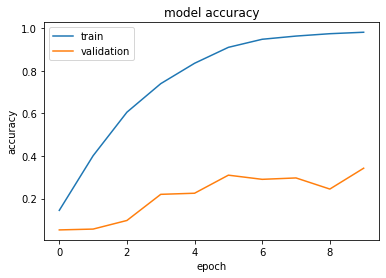

In [45]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [46]:
results_4 = keras_model_4.evaluate(X_test_ann, Y_test_ann)
print('Val_acc using batchnormalization adam : ', results_4[1])

30/30 [==============================] - 0s 14ms/step - loss: 2.4385 - accuracy: 0.3180
Val_acc using batchnormalization adam :  0.3179916441440582


In [47]:
#Store the accuracy results for each model in a dataframe for final comparison
results_adam_on_val = pd.DataFrame({'Method':['adam'], 'accuracy': results_4[1], 'loss': results_4[0]},index={'4'})
results_on_val= pd.concat([results_on_val, results_adam_on_val])
results_on_val = results_on_val[['Method', 'accuracy', 'loss']]
results_on_val

,Method,accuracy,loss
2,Batch_Norm,0.141213,2.434280
3,Weight,0.155858,2.408128
4,adam,0.317992,2.438541


# Reduce overfitting problem

- we can observe that batch size is too large and epochs are less. 

- lets reduce the batch size from 100 to 30 and epochs from 10 to 100 and callback earlystopping to avoid further overfitting 

In [48]:
#Saving the best model using model checkpoint callback
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/plantspecies_ANN_model_1.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)

In [49]:
##Initialize the Artificial Neural Network Classifier
keras_model_5 = Sequential()

# Input Layer
#Adding Input layer and activation functions ReLU
keras_model_5.add(Dense(512,kernel_initializer='he_normal',input_shape = (X_train_ann.shape[1], )))
keras_model_5.add(BatchNormalization())
#Adding Activation function
keras_model_5.add(Activation('relu'))

#Hidden Layer 1
#Adding first Hidden layer
keras_model_5.add(Dense(256,kernel_initializer='he_normal'))
keras_model_5.add(BatchNormalization())
#Adding Activation function
keras_model_5.add(Activation('relu'))

#Hidden Layer 2
#Adding second Hidden layer
keras_model_5.add(Dense(128,kernel_initializer='he_normal'))
keras_model_5.add(BatchNormalization())
#Adding Activation function
keras_model_5.add(Activation('relu'))


#Hidden Layer 3
#Adding third Hidden layer
keras_model_5.add(Dense(64,kernel_initializer='he_normal'))
keras_model_5.add(BatchNormalization())
#Adding Activation function
keras_model_5.add(Activation('relu'))


#Hidden Layer 4
#Adding fourth Hidden layer
keras_model_5.add(Dense(32,kernel_initializer='he_normal'))
keras_model_5.add(BatchNormalization())
#Adding Activation function
keras_model_5.add(Activation('relu'))


# Output Layer
#Adding output layer which is of 10 nodes (digits)
keras_model_5.add(Dense(12))
#Adding Activation function
# Here, we are using softmax function because we have multiclass classsification
keras_model_5.add(Activation('softmax'))

#compiling the ANN classifier

keras_model_5.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training data
#es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
history_2 = keras_model_5.fit(X_train_ann, Y_train_ann,  validation_split=0.2,batch_size = 30, epochs = 50, verbose = 1,callbacks=[model_checkpoint])



Epoch 1/50
102/102 [==============================] - 6s 47ms/step - loss: 2.2245 - accuracy: 0.2601 - val_loss: 2.8456 - val_accuracy: 0.1660

Epoch 00001: val_accuracy improved from -inf to 0.16601, saving model to /content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/plantspecies_ANN_model_1.h5
Epoch 2/50
102/102 [==============================] - 5s 44ms/step - loss: 1.6696 - accuracy: 0.4476 - val_loss: 2.7963 - val_accuracy: 0.1935

Epoch 00002: val_accuracy improved from 0.16601 to 0.19346, saving model to /content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/plantspecies_ANN_model_1.h5
Epoch 3/50
102/102 [==============================] - 5s 45ms/step - loss: 1.3093 - accuracy: 0.5854 - val_loss: 2.9695 - val_accuracy: 0.1935

Epoch 00003: val_accuracy did not improve from 0.19346
Epoch 4/50
102/102 [==============================] - 5s 45ms/step - loss: 1.0320 - accuracy: 0.6793 - val_loss: 2.8

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


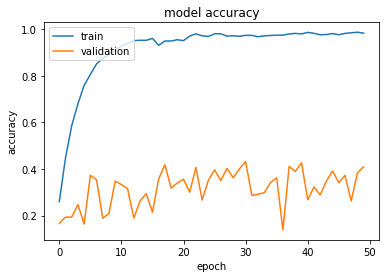

In [50]:
print(history_2.history.keys())
# "Loss"
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [51]:
from tensorflow import keras
# It can be used to reconstruct the model identically.
keras_model_5 = keras.models.load_model("/content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/plantspecies_ANN_model_1.h5")


In [52]:
results_5 = keras_model_5.evaluate(X_test_ann, Y_test_ann)
print('Val_acc using batchnormalization adam : ', results_5[1])

30/30 [==============================] - 1s 14ms/step - loss: 3.2061 - accuracy: 0.3923
Val_acc using batchnormalization adam :  0.392259418964386


In [53]:
#Store the accuracy results for each model in a dataframe for final comparison
results_adam_on_val = pd.DataFrame({'Method':['adam_batchsize'], 'accuracy': results_5[1], 'loss': results_5[0]},index={'5'})
results_on_val= pd.concat([results_on_val, results_adam_on_val])
results_on_val = results_on_val[['Method', 'accuracy', 'loss']]
results_on_val

,Method,accuracy,loss
2,Batch_Norm,0.141213,2.434280
3,Weight,0.155858,2.408128
4,adam,0.317992,2.438541
5,adam_batchsize,0.392259,3.206083


# Add dropout

In [54]:
#Saving the best model using model checkpoint callback
model_checkpoint_1=tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/plantspecies_ANN_model_2.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)

In [55]:
##Initialize the Artificial Neural Network Classifier
keras_model_6 = Sequential()

# Input Layer
#Adding Input layer and activation functions ReLU
keras_model_6.add(Dense(512,kernel_initializer='he_normal',input_shape = (X_train_ann.shape[1], )))
keras_model_6.add(BatchNormalization())
#Adding Activation function
keras_model_6.add(Activation('relu'))
keras_model_6.add(Dropout(0.2))

#Hidden Layer 1
#Adding first Hidden layer
keras_model_6.add(Dense(256,kernel_initializer='he_normal'))
keras_model_6.add(BatchNormalization())
#Adding Activation function
keras_model_6.add(Activation('relu'))
keras_model_6.add(Dropout(0.2))

#Hidden Layer 2
#Adding second Hidden layer
keras_model_6.add(Dense(128,kernel_initializer='he_normal'))
keras_model_6.add(BatchNormalization())
#Adding Activation function
keras_model_6.add(Activation('relu'))
keras_model_6.add(Dropout(0.2))


#Hidden Layer 3
#Adding third Hidden layer
keras_model_6.add(Dense(64,kernel_initializer='he_normal'))
keras_model_6.add(BatchNormalization())
#Adding Activation function
keras_model_6.add(Activation('relu'))
keras_model_6.add(Dropout(0.2))

#Hidden Layer 4
#Adding fourth Hidden layer
keras_model_6.add(Dense(32,kernel_initializer='he_normal'))
keras_model_6.add(BatchNormalization())
#Adding Activation function
keras_model_6.add(Activation('relu'))
keras_model_6.add(Dropout(0.2))

# Output Layer
#Adding output layer which is of 12 nodes 
keras_model_6.add(Dense(12))
#Adding Activation function
# Here, we are using softmax function because we have multiclass classsification
keras_model_6.add(Activation('softmax'))

#compiling the ANN classifier

keras_model_6.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training data
#es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
history_3 = keras_model_6.fit(X_train_ann, Y_train_ann,  validation_split=0.2,batch_size = 30, epochs = 50, verbose = 1,callbacks=[model_checkpoint_1])


Epoch 1/50
102/102 [==============================] - 7s 48ms/step - loss: 2.6754 - accuracy: 0.1067 - val_loss: 2.9521 - val_accuracy: 0.1294

Epoch 00001: val_accuracy improved from -inf to 0.12941, saving model to /content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/plantspecies_ANN_model_2.h5
Epoch 2/50
102/102 [==============================] - 5s 45ms/step - loss: 2.2494 - accuracy: 0.2392 - val_loss: 2.2072 - val_accuracy: 0.2706

Epoch 00002: val_accuracy improved from 0.12941 to 0.27059, saving model to /content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/plantspecies_ANN_model_2.h5
Epoch 3/50
102/102 [==============================] - 5s 45ms/step - loss: 2.0356 - accuracy: 0.3171 - val_loss: 2.1014 - val_accuracy: 0.2667

Epoch 00003: val_accuracy did not improve from 0.27059
Epoch 4/50
102/102 [==============================] - 5s 45ms/step - loss: 1.8091 - accuracy: 0.3966 - val_loss: 2.0

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


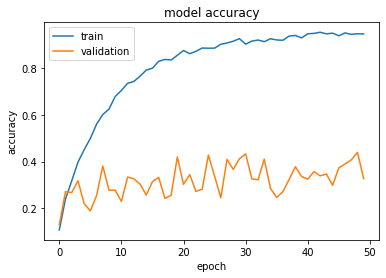

In [56]:
print(history_3.history.keys())
# "Loss"
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [57]:
from tensorflow import keras
# It can be used to reconstruct the model identically.
keras_model_6 = keras.models.load_model("/content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/plantspecies_ANN_model_2.h5")


In [58]:
results_6 = keras_model_6.evaluate(X_test_ann, Y_test_ann)
print('Val_acc using batchnormalization adam : ', results_6[1])

30/30 [==============================] - 1s 14ms/step - loss: 2.8546 - accuracy: 0.4393
Val_acc using batchnormalization adam :  0.4393305480480194


In [59]:
#Store the accuracy results for each model in a dataframe for final comparison
results_adam_on_val = pd.DataFrame({'Method':['adam_batchsize_dropout'], 'accuracy': results_6[1], 'loss': results_6[0]},index={'6'})
results_on_val= pd.concat([results_on_val, results_adam_on_val])
results_on_val = results_on_val[['Method', 'accuracy', 'loss']]
results_on_val

,Method,accuracy,loss
2,Batch_Norm,0.141213,2.434280
3,Weight,0.155858,2.408128
4,adam,0.317992,2.438541
5,adam_batchsize,0.392259,3.206083
6,adam_batchsize_dropout,0.439331,2.854647


# we can improve the accuracy by reducing the learning rate to 0.0001

In [62]:
#Saving the best model using model checkpoint callback
model_checkpoint_2=tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/plantspecies_ANN_model_3.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)

In [63]:
##Initialize the Artificial Neural Network Classifier
keras_model_7 = Sequential()

# Input Layer
#Adding Input layer and activation functions ReLU
keras_model_7.add(Dense(512,kernel_initializer='he_normal',input_shape = (X_train_ann.shape[1], )))
keras_model_7.add(BatchNormalization())
#Adding Activation function
keras_model_7.add(Activation('relu'))
keras_model_7.add(Dropout(0.2))

#Hidden Layer 1
#Adding first Hidden layer
keras_model_7.add(Dense(256,kernel_initializer='he_normal'))
keras_model_7.add(BatchNormalization())
#Adding Activation function
keras_model_7.add(Activation('relu'))
keras_model_7.add(Dropout(0.2))

#Hidden Layer 2
#Adding second Hidden layer
keras_model_7.add(Dense(128,kernel_initializer='he_normal'))
keras_model_7.add(BatchNormalization())
#Adding Activation function
keras_model_7.add(Activation('relu'))
keras_model_7.add(Dropout(0.2))


#Hidden Layer 3
#Adding third Hidden layer
keras_model_7.add(Dense(64,kernel_initializer='he_normal'))
keras_model_7.add(BatchNormalization())
#Adding Activation function
keras_model_7.add(Activation('relu'))
keras_model_7.add(Dropout(0.2))

#Hidden Layer 4
#Adding fourth Hidden layer
keras_model_7.add(Dense(32,kernel_initializer='he_normal'))
keras_model_7.add(BatchNormalization())
#Adding Activation function
keras_model_7.add(Activation('relu'))
keras_model_7.add(Dropout(0.2))

# Output Layer
#Adding output layer which is of 12 nodes
keras_model_7.add(Dense(12))
#Adding Activation function
# Here, we are using softmax function because we have multiclass classsification
keras_model_7.add(Activation('softmax'))

#compiling the ANN classifier
# Learning rate reduced to 0.0001
from keras.optimizers import adam_v2
Adam_lr =  adam_v2.Adam(learning_rate=0.0001)

keras_model_7.compile(optimizer = Adam_lr, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training data
history_4 = keras_model_7.fit(X_train_ann, Y_train_ann,  validation_split=0.2,batch_size = 30, epochs = 100, verbose = 1,callbacks=[model_checkpoint_2])

Epoch 1/100
102/102 [==============================] - 6s 48ms/step - loss: 2.7086 - accuracy: 0.1090 - val_loss: 2.5205 - val_accuracy: 0.1072

Epoch 00001: val_accuracy improved from -inf to 0.10719, saving model to /content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/plantspecies_ANN_model_3.h5
Epoch 2/100
102/102 [==============================] - 5s 46ms/step - loss: 2.5410 - accuracy: 0.1505 - val_loss: 2.4502 - val_accuracy: 0.0915

Epoch 00002: val_accuracy did not improve from 0.10719
Epoch 3/100
102/102 [==============================] - 5s 46ms/step - loss: 2.4408 - accuracy: 0.1672 - val_loss: 2.3853 - val_accuracy: 0.1673

Epoch 00003: val_accuracy improved from 0.10719 to 0.16732, saving model to /content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/plantspecies_ANN_model_3.h5
Epoch 4/100
102/102 [==============================] - 5s 46ms/step - loss: 2.3627 - accuracy: 0.1947 - val_loss:

In [64]:
from tensorflow import keras
# It can be used to reconstruct the model identically.
keras_model_7 = keras.models.load_model("/content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/plantspecies_ANN_model_3.h5")


In [65]:
results_7 = keras_model_7.evaluate(X_test_ann, Y_test_ann)
print('Val_acc using batchnormalization adam : ', results_7[1])

30/30 [==============================] - 1s 15ms/step - loss: 1.7991 - accuracy: 0.4351
Val_acc using batchnormalization adam :  0.4351464509963989


In [66]:
#Store the accuracy results for each model in a dataframe for final comparison
results_adam_on_val = pd.DataFrame({'Method':['adam_batchsize_dropout'], 'accuracy': results_7[1], 'loss': results_7[0]},index={'7'})
results_on_val= pd.concat([results_on_val, results_adam_on_val])
results_on_val = results_on_val[['Method', 'accuracy', 'loss']]
results_on_val

,Method,accuracy,loss
2,Batch_Norm,0.141213,2.434280
3,Weight,0.155858,2.408128
4,adam,0.317992,2.438541
5,adam_batchsize,0.392259,3.206083
6,adam_batchsize_dropout,0.439331,2.854647
7,adam_batchsize_dropout,0.435146,1.799090


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


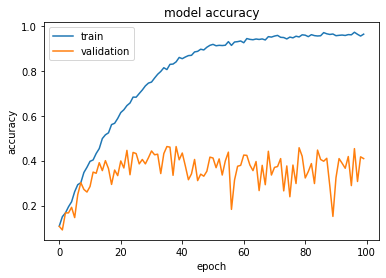

In [67]:
print(history_4.history.keys())
# "Loss"
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Let increase the number of nodes in hidden layers

In [73]:
#Saving the best model using model checkpoint callback
model_checkpoint_3=tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/plantspecies_ANN_model_4.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)

In [74]:
##Initialize the Artificial Neural Network Classifier
keras_model_8 = Sequential()

# Input Layer
#Adding Input layer and activation functions ReLU
keras_model_8.add(Dense(5000,kernel_initializer='he_normal',input_shape = (X_train_ann.shape[1], )))
keras_model_8.add(BatchNormalization())
#Adding Activation function
keras_model_8.add(Activation('relu'))
keras_model_8.add(Dropout(0.2))

#Hidden Layer 1
#Adding first Hidden layer
keras_model_8.add(Dense(2000,kernel_initializer='he_normal'))
keras_model_8.add(BatchNormalization())
#Adding Activation function
keras_model_8.add(Activation('relu'))
keras_model_8.add(Dropout(0.2))

#Hidden Layer 2
#Adding second Hidden layer
keras_model_8.add(Dense(750,kernel_initializer='he_normal'))
keras_model_8.add(BatchNormalization())
#Adding Activation function
keras_model_8.add(Activation('relu'))
keras_model_8.add(Dropout(0.2))

#Hidden Layer 3
#Adding third Hidden layer
keras_model_8.add(Dense(256,kernel_initializer='he_normal'))
keras_model_8.add(BatchNormalization())
#Adding Activation function
keras_model_8.add(Activation('relu'))
keras_model_8.add(Dropout(0.2))

#Hidden Layer 4
#Adding fourth Hidden layer
keras_model_8.add(Dense(64,kernel_initializer='he_normal'))
keras_model_8.add(BatchNormalization())
#Adding Activation function
keras_model_8.add(Activation('relu'))
keras_model_8.add(Dropout(0.2))

# Output Layer
#Adding output layer which is of 12 nodes
keras_model_8.add(Dense(12))
#Adding Activation function
# Here, we are using softmax function because we have multiclass classsification
keras_model_8.add(Activation('softmax'))


#compiling the ANN classifier
# Learning rate reduced to 0.0001
from keras.optimizers import adam_v2
Adam_lr =  adam_v2.Adam(learning_rate=0.0001)

keras_model_8.compile(optimizer = Adam_lr, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training data
history_4 = keras_model_8.fit(X_train_ann, Y_train_ann,  validation_split=0.2,batch_size = 30, epochs = 100, verbose = 1,callbacks=[model_checkpoint_3])

Epoch 1/100
102/102 [==============================] - 51s 481ms/step - loss: 2.6231 - accuracy: 0.1440 - val_loss: 2.5258 - val_accuracy: 0.1163

Epoch 00001: val_accuracy improved from -inf to 0.11634, saving model to /content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/plantspecies_ANN_model_4.h5
Epoch 2/100
102/102 [==============================] - 53s 517ms/step - loss: 2.1154 - accuracy: 0.2925 - val_loss: 2.2706 - val_accuracy: 0.2288

Epoch 00002: val_accuracy improved from 0.11634 to 0.22876, saving model to /content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/plantspecies_ANN_model_4.h5
Epoch 3/100
102/102 [==============================] - 53s 515ms/step - loss: 1.8068 - accuracy: 0.4002 - val_loss: 2.1648 - val_accuracy: 0.2654

Epoch 00003: val_accuracy improved from 0.22876 to 0.26536, saving model to /content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classifica

In [75]:
from tensorflow import keras
# It can be used to reconstruct the model identically.
keras_model_8 = keras.models.load_model("/content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/plantspecies_ANN_model_4.h5")


In [76]:
results_8 = keras_model_8.evaluate(X_test_ann, Y_test_ann)
print('Val_acc using batchnormalization adam : ', results_8[1])

30/30 [==============================] - 5s 136ms/step - loss: 1.7018 - accuracy: 0.4686
Val_acc using batchnormalization adam :  0.4686192572116852


In [77]:
#Store the accuracy results for each model in a dataframe for final comparison
results_adam_on_val = pd.DataFrame({'Method':['Input_dropout_50%'], 'accuracy': results_8[1], 'loss': results_8[0]},index={'8'})
results_on_val= pd.concat([results_on_val, results_adam_on_val])
results_on_val = results_on_val[['Method', 'accuracy', 'loss']]
results_on_val

,Method,accuracy,loss
2,Batch_Norm,0.141213,2.434280
3,Weight,0.155858,2.408128
4,adam,0.317992,2.438541
5,adam_batchsize,0.392259,3.206083
6,adam_batchsize_dropout,0.439331,2.854647
7,adam_batchsize_dropout,0.435146,1.799090
8,Input_dropout_50%,0.468619,1.701758


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


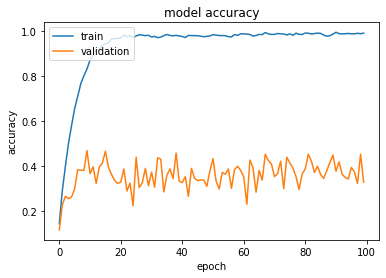

In [78]:
print(history_4.history.keys())
# "Loss"
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Summary of ANN**

By tuning different hyper parameters we are able to acheive the accuracy score of 46.9%.

As explained, ANN is more sutaible for smaller dataset. For larger dataasets it becomes computationally expensive. 

Here images are resized to 64*64 to decrease number of parameters with that it becomes difficult for the model to validate well.

<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#00b3e5;">2.3) Model Preparation using CNN

Plot an image from training data set

In [ ]:
from IPython.display import clear_output
train_images = []
train_labels = []
a=0
for cat in listing: 
  path=os.path.join(pathToTrain,cat)
  #class_num = listing.(cat)
  for img in os.listdir(path):
    image = os.path.join(path, img)
    train_images.append(cv2.resize(cv2.imread(image), (64, 64)))
    train_labels.append(cat)
    a+=1
  clear_output()
  print(a)
train_X = np.asarray(train_images)
train_Y = pd.DataFrame(train_labels)

4777


In [ ]:
train_X.shape

(4777, 64, 64, 3)

Print all unique output classes

In [ ]:
train_Y[0].unique()

array(['Charlock', 'Common wheat', 'Fat Hen', 'Cleavers', 'Maize',
       'Black-grass', 'Loose Silky-bent', 'Common Chickweed',
       'Shepherds Purse', 'Small-flowered Cranesbill',
       'Scentless Mayweed', 'Sugar beet'], dtype=object)

In [ ]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# Converting labels to numbers
encoder = LabelEncoder()
encoder.fit(train_Y[0])
encoded_labels = encoder.transform(train_Y[0])
categorical_labels = np_utils.to_categorical(encoded_labels)


In [ ]:
print(encoded_labels)

[ 1  1  1 ... 11 11 11]


Split X and y into training and test set in 80:20 ratio

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(train_X, categorical_labels, test_size = 0.20, random_state = 8)   #split the data into train nd validation data


Normalize the train and validation images

In [21]:
# Normalization of the Image Data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255 

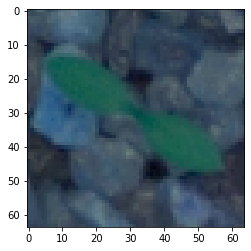

In [ ]:
plt.imshow(x_train[0])

Initialize the object of ImageDataGenerator

In [24]:
datagen= tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                         width_shift_range=0.2,
                                                         height_shift_range=0.2,
                                                         zoom_range=[0.4,1.5],
                                                         horizontal_flip=True,
                                                         vertical_flip=True)

datagen.fit(x_train)

**Initialize and build the model**

In [25]:
#Clear any previous model from memory
tf.keras.backend.clear_session()

#Initialize model
model = tf.keras.models.Sequential()

#Add 1st Conv Layer
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), input_shape=(64, 64, 3), activation='relu'))

#Add 2nd Conv Layer
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))

#normalize data
model.add(tf.keras.layers.BatchNormalization())

#Add Max Pool layer
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#Add 3rd Conv Layer
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu'))

#normalize data
model.add(tf.keras.layers.BatchNormalization())

#Add Max Pool layer
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#Add 4th Conv Layer
model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu'))

#normalize data
model.add(tf.keras.layers.BatchNormalization())

#Add Max Pool layer
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#Add Global Max Pool layer
model.add(tf.keras.layers.GlobalMaxPool2D())

#Flatten the data
model.add(tf.keras.layers.Flatten())

#Add 1st dense layer
model.add(tf.keras.layers.Dense(128, activation='relu'))

#normalize data
model.add(tf.keras.layers.BatchNormalization())

#Add Dropout
model.add(tf.keras.layers.Dropout(0.3))

#Add 2nd dense layer
model.add(tf.keras.layers.Dense(128, activation='relu'))

#normalize data
model.add(tf.keras.layers.BatchNormalization())

#Add Dropout
model.add(tf.keras.layers.Dropout(0.3))

#Add Output Layer
model.add(tf.keras.layers.Dense(12, activation='softmax'))

Compile the model

In [26]:
#Specify Lass and Optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model Summary

In [ ]:
#Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0

In [27]:
#Saving the best model using model checkpoint callback
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/plantspecies_CNN_model.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)

Fit the model

In [29]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=32), 
                    epochs=25, validation_data=(x_test, y_test),   
                    callbacks = [model_checkpoint])

Epoch 1/25
120/120 [==============================] - 166s 1s/step - loss: 0.4298 - accuracy: 0.8424 - val_loss: 0.4582 - val_accuracy: 0.8337

Epoch 00001: val_accuracy improved from 0.82113 to 0.83368, saving model to /content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/plantspecies_CNN_model.h5
Epoch 2/25
120/120 [==============================] - 170s 1s/step - loss: 0.4546 - accuracy: 0.8427 - val_loss: 0.4789 - val_accuracy: 0.8222

Epoch 00002: val_accuracy did not improve from 0.83368
Epoch 3/25
120/120 [==============================] - 176s 1s/step - loss: 0.4040 - accuracy: 0.8597 - val_loss: 0.3339 - val_accuracy: 0.8724

Epoch 00003: val_accuracy improved from 0.83368 to 0.87238, saving model to /content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/plantspecies_CNN_model.h5
Epoch 4/25
120/120 [==============================] - 168s 1s/step - loss: 0.3955 - accuracy: 0.8626 - val_loss: 0.77

**4) Final best model of CNN is saved using ModelCheckpoint and loaded as below** 

In [30]:
from tensorflow import keras
# It can be used to reconstruct the model identically.
Final_model = keras.models.load_model("/content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/plantspecies_CNN_model.h5")


Predict the accuracy for both train and validation data

In [31]:
#Final score and accuracy of the model
loss, acc = Final_model.evaluate(x_test,y_test)
loss1, acc1 = Final_model.evaluate(x_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)

120/120 [==============================] - 37s 306ms/step - loss: 0.2179 - accuracy: 0.9212
Test loss: 0.3145900070667267    Test accuracy: 0.8912134170532227
Train loss: 0.21785277128219604    Train accuracy: 0.92122483253479


Model accuracy can be improved further by increasing number of epochs from 25 to 100. But restricted to 25 as computational time will be more for `100 epochs.`

Plot the accuracy and loss graph for train and validation set

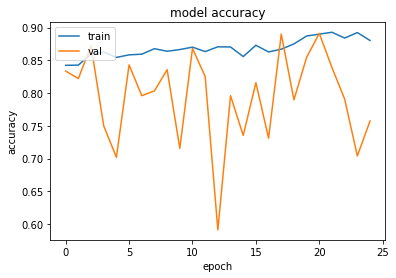

In [32]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

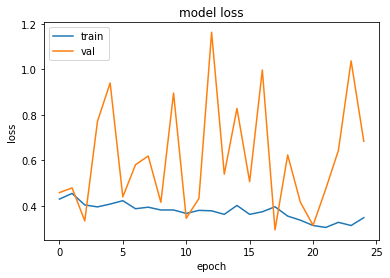

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 2.4) Using Transfer Learning (additional)

Download the vgg wieght file from here : https://github.com/MinerKasch/applied_deep_learning/blob/master/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# Instantiate the model with the pre-trained weights (no top)
base_model= VGG16(weights=('/content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/VGG_data/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'),
                 include_top=False,input_shape = (64, 64, 3), pooling='avg')

Since we don’t have to train all the layers, we make them non_trainable:

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

# Compile and Fit

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.2)(x)

# Add a final softmax layer with 12 node for classification output
x = layers.Dense(12, activation='softmax')(x)

model_Transfer = tf.keras.models.Model(base_model.input, x)
from keras.optimizers import adam_v2

Adam_lr =  adam_v2.Adam(learning_rate=0.0001)

model_Transfer.compile(optimizer = Adam_lr, loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
#Saving the best model using model checkpoint callback
model_checkpoint_1=tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/plantspecies_transfer_model.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)

In [ ]:
vgghist = model_Transfer.fit(x_train, y_train, validation_data=(x_test, y_test),   
                    callbacks = [model_checkpoint_1], steps_per_epoch = 100, epochs = 25)

Epoch 1/25
100/100 [==============================] - 175s 2s/step - loss: 2.3818 - accuracy: 0.1793 - val_loss: 2.2721 - val_accuracy: 0.2469

Epoch 00001: val_accuracy improved from -inf to 0.24686, saving model to /content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/plantspecies_transfer_model.h5
Epoch 2/25
100/100 [==============================] - 174s 2s/step - loss: 2.2062 - accuracy: 0.2729 - val_loss: 2.1572 - val_accuracy: 0.2657

Epoch 00002: val_accuracy improved from 0.24686 to 0.26569, saving model to /content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classification Data/plantspecies_transfer_model.h5
Epoch 3/25
100/100 [==============================] - 174s 2s/step - loss: 2.0801 - accuracy: 0.3352 - val_loss: 2.0452 - val_accuracy: 0.3567

Epoch 00003: val_accuracy improved from 0.26569 to 0.35669, saving model to /content/gdrive/MyDrive/GL_Projects/Computer_Vision/Part-1 - Plant Seedling Classificatio

Accuracy of model using transfer learning is acheived around 52.82%. I think i need to build model properly to improve the accuracy.

<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#00b3e5;">3)Compare the results from the above step along with your detailed observations on the best performing algorithm and why/how it outperforms other algorithms in this case

In [15]:
# Final results from each supervised, nueral network and CNN are mentioned below.

# From supervised
results= pd.DataFrame({'Method':['Supervised_SVM','NN','CNN'], 'accuracy': [47.38,46.8,89.6]}, index={'1','2','3'})
#results_on_val= pd.concat([results_on_val, results_adam_on_val])
final_result = results[['Method', 'accuracy']]
final_result


,Method,accuracy
3,Supervised_SVM,47.38
2,NN,46.80
1,CNN,89.60


**Summary :  CNN model outperforms of nueral network and supervised algorithms**

**Explanation :** CNN performs well and is highly popular because of its architecture. the best thing is there is no need for feature extraction. The system learns to do feature extraction and the core concept of CNN is, it uses convolution of image and filters to generate invariant features which are passed on to the next layer.

When using CNN for image classification, these spatial features are extracted from image input. This makes CNN ideal when thousands of features need to be extracted. Instead of having to measure each individual feature, CNN gathers these features on its own.

Using ANN, image classification problems become difficult because 2-dimensional images need to be converted to 1-dimensional vectors. This increases the number of trainable parameters exponentially. Increasing trainable parameters takes storage and processing capability.


**4) Final best model of CNN is also saved,loaded and evaluated as below**

In [40]:
from keras.models import load_model
# save the model
model.save("D:\\AIML\\Deep_Learning\\GL_Projects\\Final_model.h5")

#Load the model
model_CNN = load_model("D:\\AIML\\Deep_Learning\\GL_Projects\\Final_model.h5")

In [41]:
#Final score and accuracy of the model
loss, acc = model_CNN.evaluate(x_test,y_test)
loss1, acc1 = model_CNN.evaluate(x_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)

120/120 [==============================] - 38s 313ms/step - loss: 0.4675 - accuracy: 0.8129
Test loss: 0.6840736269950867    Test accuracy: 0.7573221921920776
Train loss: 0.4675460755825043    Train accuracy: 0.8128762245178223


5) Import the the test image [ from the “ Prediction” folder ] to predict the class. Display the image. Use the best trained 
image classifier model to predict the class. 


In [ ]:
pics = glob(testPath)
testimages = []
tests = []
count=1
num = len(pics)
for i in pics:
    print(str(count)+'/'+str(num),end='r')
    tests.append(i.split('/')[-1])
    testimages.append(cv2.resize(cv2.imread(i),(64,64)))
    count = count + 1
testimages = np.asarray(testimages)

1/1r

In [ ]:
# Normalization of the Image Data
test_X = testimages.astype('float32') / 255

In [ ]:
prediction = Final_model.predict(test_X)
pred = np.argmax(prediction,axis=1)
predStr = encoder.classes_[pred]
print(predStr)

['Maize']


# As per CNN am able to predict the sample as Maize